In [1]:
import matplotlib.pyplot as plt
import numpy as np
import warnings

from mpl_toolkits.mplot3d import Axes3D
from collections import namedtuple
from scipy.interpolate import CubicSpline, UnivariateSpline, RectBivariateSpline
from vol import heston

warnings.filterwarnings('ignore')

In [2]:
myheston = heston.Heston(s=100, v=1, kappa=1, theta=0.4, sigma=0.4, rho=0.5, r=0.05)

T_grid = np.linspace(0.2, 1, 7)
K_grid = np.linspace(60, 140, 10)

call_prices = myheston.call_price(T_grid.reshape(-1, 1), K_grid)
implied_volatilities = myheston.iv(T_grid.reshape(-1, 1), K_grid)

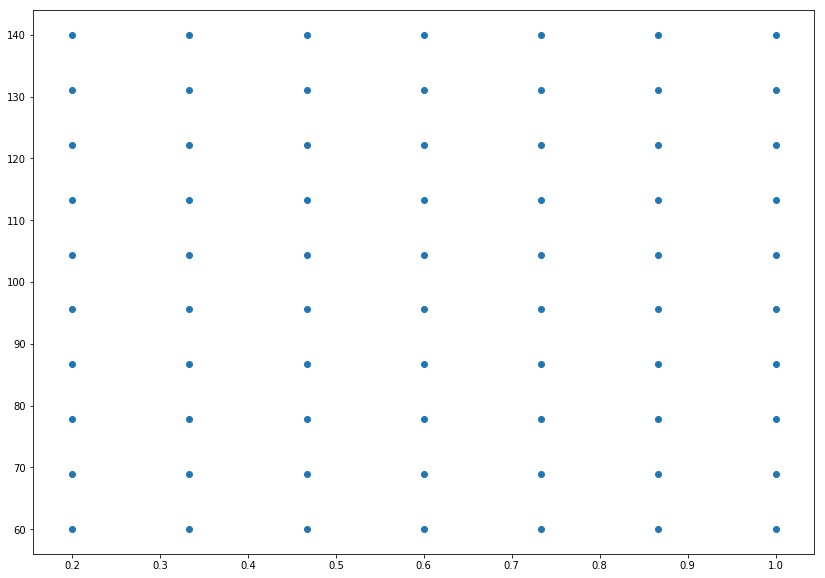

In [3]:
plt.figure(figsize=(14, 10))

plt.scatter(*np.meshgrid(T_grid, K_grid))

plt.show()

In [ ]:
class LocalVolatility:
    
    def __init__(self):
        pass
    

In [4]:
def construct_new_grid(iv, K_grid, T_grid):
    
    initial_price = 100
    
    y = np.log(np.repeat(K_grid.reshape(1, -1), len(T_grid), axis=0)) - np.log(initial_price)
    w = np.repeat(T_grid.reshape(1, -1), len(K_grid), axis=0).T * np.square(iv)
    
    return y, w

def make_implied_volatility_surface(iv, K_grid, T_grid, y, w, y_extended, w_extended):
    
    Theta = np.zeros_like(y_extended)
    dTheta_dy = np.zeros_like(y_extended)
    d2Theta_dy = np.zeros_like(y_extended)
    dTheta_dw = np.zeros_like(y_extended)
    
    w_k_extended = np.zeros((len(T_grid), y_extended.shape[1]))
    tmp = np.zeros((len(T_grid), y_extended.shape[1]))
    tmp1 = np.zeros((len(T_grid), y_extended.shape[1]))
    tmp2 = np.zeros((len(T_grid), y_extended.shape[1]))
    
    # iterate over time
    for i in range(len(T_grid)):
        spline = CubicSpline(y[i], iv[i], bc_type='natural')
       
        tmp[i] = spline(y_extended[i])
        tmp1[i] = spline.derivative(nu=1)(y_extended[i])
        tmp2[i] = spline.derivative(nu=2)(y_extended[i])
    
    # suspicious
    for i in range(len(T_grid)):
        spline = CubicSpline(y[i], w[i], bc_type='natural')
        w_k_extended[i] = spline(y_extended[i])
    
    # iterate over strikes
    for j in range(y_extended.shape[1]):
        spline = UnivariateSpline(w_k_extended[:, j], tmp1[:, j], k=1)
        dTheta_dy[:, j] = spline(w_extended[:, j])
    
    for j in range(y_extended.shape[1]):
        spline = UnivariateSpline(w_k_extended[:, j], tmp2[:, j], k=1)
        d2Theta_dy[:, j] = spline(w_extended[:, j])
        
    for j in range(y_extended.shape[1]):
        spline = UnivariateSpline(w_k_extended[:, j], tmp[:, j], k=1)
        Theta[:, j] = spline(w_extended[:, j])
        dTheta_dw = spline.derivative(n=1)(w_extended[:, j])
    
    return Theta, dTheta_dy, d2Theta_dy, dTheta_dw

def calculate_local_volatility(y_extended, w_extended, Theta, dTheta_dy, d2Theta_dy, dTheta_dw):
    
    r = 0.05
    
    d1_sqrt_t = (-y_extended + r * w_extended / np.square(Theta) + 0.5 * w_extended) / Theta
    num = (Theta ** 3) / (Theta - 2 * w_extended * dTheta_dw) + 2 * r * w_extended * dTheta_dy
    denum = ((1 + d1_sqrt_t * dTheta_dy) ** 2) +\
        w_extended / Theta * (d2Theta_dy - dTheta_dy - d1_sqrt_t * np.square(dTheta_dy))
    
    return np.sqrt(np.maximum(num / denum, np.zeros_like(Theta)))

def extend_grid(iv, y, w):
    
    gamma = 1 # from paper

    ind = np.argmin(np.abs(np.log(y)))
    ATM_iv = iv[:, ind] # BS implied vol of ATM market options
    D = gamma * np.mean(ATM_iv) * np.sqrt(np.max(w))

    N = 500
    
    w_values = np.linspace(np.min(w), np.max(w), N + 1)
    # y_values = np.linspace(np.min(y), np.max(y), N + 1)
    y_values = np.linspace(-D, D, N + 1)

    return np.meshgrid(y_values, w_values)

def calibrate(iv, K_grid, T_grid):
    
    y, w = construct_new_grid(iv, K_grid, T_grid)
    # print(w)
    
    y_extended, w_extended = extend_grid(iv, y, w)
    
    # print(w_extended.min(), w_extended.max())
    
    parameters = make_implied_volatility_surface(iv, K_grid, T_grid, y, w, y_extended, w_extended)
    
    return y_extended, w_extended, calculate_local_volatility(
        y_extended, w_extended,
        *parameters
    ), parameters[0]


In [5]:
y_extended, w_extended, loc_vol, theta = calibrate(implied_volatilities, K_grid, T_grid)

In [6]:
K_extended = np.exp(y_extended) * 100
T_extended = w_extended / theta / theta

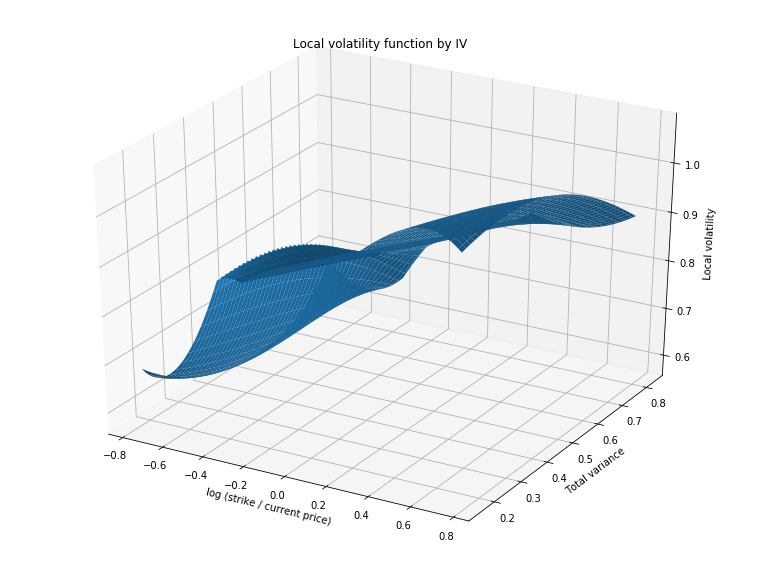

In [7]:
fig = plt.figure(figsize=(45, 10))

ax2 = fig.add_subplot(132, projection='3d')
ax2.plot_surface(y_extended, w_extended, loc_vol)
ax2.set_title('Local volatility function by IV')
ax2.set_xlabel('log (strike / current price)')
ax2.set_ylabel('Total variance')
ax2.set_zlabel('Local volatility')
# ax2.set_zlim(0.0, 0.5)

plt.show()

$V_t + (r - q - \frac{1}{2} \sigma^2)V_x + \frac{1}{2} \sigma^2 V_{xx} = rV$, $\;\;\;\nu := r - q - \frac{1}{2} \sigma^2$

$\frac{V^{i}_j - V^{i - 1}_j}{\tau} + \nu^{i - 1}_j \frac{V^{i - 1}_{j + 1} - V^{i - 1}_{j - 1}}{2 h} + \frac{1}{2} (\sigma^2)^{i - 1}_j \frac{V^{i - 1}_{j - 1} - 2 V^{i - 1}_j + V^{i - 1}_{j + 1}}{h^2} = r V^{i - 1}_j$

$\left(-\frac{\nu^{i - 1}_j}{2 h} + \frac{1}{2 h^2} (\sigma^2)^{i - 1}_j \right)V^{i - 1}_{j - 1} + \left(-\frac{1}{\tau} - \frac{1}{h^2} (\sigma^2)^{i - 1}_j - r\right) V^{i - 1}_j + \left(\frac{\nu^{i - 1}_j}{2 h} + \frac{1}{2 h^2} (\sigma^2)^{i - 1}_j \right) V^{i - 1}_{j + 1} = -\frac{1}{\tau} V^i_j$

$\left(\frac{\tau \nu^{i - 1}_j}{2 h} - \frac{\tau}{2 h^2} (\sigma^2)^{i - 1}_j \right)V^{i - 1}_{j - 1} + \left(1 + \frac{\tau}{h^2} (\sigma^2)^{i - 1}_j + r\tau \right) V^{i - 1}_j + \left(-\frac{\tau \nu^{i - 1}_j}{2 h} - \frac{\tau}{2 h^2} (\sigma^2)^{i - 1}_j \right) V^{i - 1}_{j + 1} = V^i_j$

$V^i_0 - V^i_1 = 0, \;\;\; V^i_{M} - V^i_{M - 1} = S[M] - S[M - 1], \;\;\; V^N_j = (S[j] - K)^+$

In [8]:
def progonka_final(c, d, e, b):
    """
    Solves the following system of linear equations (w.r.t. x = (x[0], x[1], ..., x[n - 1])):

    d[0] * x[0] + e[0] * x[1] = b[0],
    c[0] * x[0] + d[1] * x[1] + e[1] * x[2] = b[1],
    ...
    c[i - 1] * x[i - 1] + d[i] * x[i] + e[i] * x[i + 1] = b[i],
    ...
    c[n - 3] * x[n - 3] + d[n - 2] * x[n - 2] + e[n - 2] * x[n - 1] = b[n - 2],
    c[n - 2] * x[n - 2] + d[n - 1] * x[n - 1] = b[n - 1]

    """
    n = len(b)
    alpha, beta = np.zeros(n - 1), np.zeros(n - 1)
    alpha[0], beta[0] = -e[0] / d[0], b[0] / d[0]
    
    for i in range(1, n - 1):
        alpha[i] = -e[i] / (d[i] + c[i - 1] * alpha[i - 1])
        beta[i] = (-c[i - 1] * beta[i - 1] + b[i]) / (d[i] + c[i - 1] * alpha[i - 1])
        
    ans = np.zeros(n)
    ans[-1] = (-c[-1] * beta[-1] + b[-1]) / (d[-1] + c[-1] * alpha[-1])
    
    for i in range(n - 2, -1, -1):
        ans[i] = ans[i + 1] * alpha[i] + beta[i]
        
    return ans

In [9]:
N = 500
r = 0.05
K = 120
S = K_extended[0]
tau, h = T_grid.max() / N, np.log(K_extended[0, 1] / K_extended[0, 0])

def c(nu, tau, h, sigma):
    return nu / 2 / h - np.square(sigma) / 2 / h / h
    # return tau * nu / 2 / h - tau * np.square(sigma) / 2 / h / h

def d(tau, h, sigma, r = 0):
    return 1 / tau + 1 / h / h * np.square(sigma) + r
    # return 1 + tau / h / h * np.square(sigma) + r * tau

def e(nu, tau, h, sigma):
    return -nu / 2 / h - np.square(sigma) / 2 / h / h
    # return -tau * nu / 2 / h - tau * np.square(sigma) / 2 / h / h

V = np.zeros_like(loc_vol)

V[-1] = np.maximum(S - K, np.zeros_like(S - K))

for i in range(N, 0, -1):
    nu = r - 0.5 * (loc_vol[i - 1, 1:-1] ** 2)
    c_current = np.array(list(c(nu, tau, h, loc_vol[i - 1, 1:-1])) + [-1])
    d_current = np.array([1] + list(d(tau, h, loc_vol[i - 1, 1:-1], r)) + [1])
    e_current = np.array([-1] + list(e(nu, tau, h, loc_vol[i - 1, 1:-1])))
    
    b = np.array([0] + list(V[i, 1:-1] / tau) + [S[-1] - S[-2]])
    V[i - 1] = progonka_final(c_current, d_current, e_current, b)

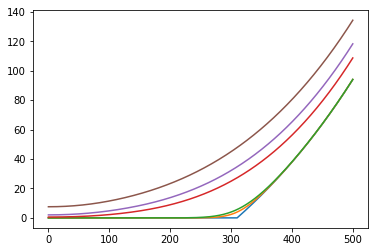

In [10]:
plt.plot(V[500])
plt.plot(V[495])
plt.plot(V[490])
plt.plot(V[300])
plt.plot(V[200])
plt.plot(V[0])

In [24]:
stock_prices = myheston.simulate_euler(T_grid[-1], N, 1)

In [39]:
spline = CubicSpline(S, V[0], bc_type='natural')
money_account = spline(stock_prices[0])
print('call price =', money_account)
delta = 0

money = []
V_trajectory = []

for i in range(N):
    spline = CubicSpline(S, V[i], bc_type='natural')
    V_trajectory.append(spline(stock_prices[i]))
    new_delta = spline.derivative(nu=1)(stock_prices[i])
    # print(delta, stock_prices[i])
    money_account -= (new_delta - delta) * stock_prices[i]
    money_account *= np.exp(r * (T_extended[i + 1, 0] - T_extended[i, 0]))
    delta = new_delta
    money.append(money_account + delta * stock_prices[i])
    
money, V_trajectory = np.array(money), np.array(V_trajectory)

money_account, money[-1], stock_prices[-1]
print('payoff is', np.maximum(stock_prices[-1][0] - K, 0))
print('our money is', money_account + delta * stock_prices[-1])

call price = [32.70342322]
payoff is 12.750456179215519
our money is [13.79454219]


In [41]:
import scipy.stats as sps

spline = CubicSpline(S, V[0], bc_type='natural')
money_account_bs = spline(stock_prices[0])
print('call price =', money_account_bs)
delta_bs = 0

money_bs = []
V_trajectory_bs = []

for i in range(N):
    spline = CubicSpline(S, V[i], bc_type='natural')
    V_trajectory_bs.append(spline(stock_prices[i]))
    spline_theta = CubicSpline(S, theta[i], bc_type='natural')
    volatility = spline_theta(stock_prices[i])
    d1_num = np.log(stock_prices[i] / K) + (volatility * volatility / 2 + r) * (T_extended[-1, 0] - T_extended[i, 0])
    d1_denum = volatility * np.sqrt(T_extended[-1, 0] - T_extended[i, 0])
    new_delta_bs = sps.norm.cdf(d1_num / d1_denum)
    # print(delta, stock_prices[i])
    money_account_bs -= (new_delta_bs - delta_bs) * stock_prices[i]
    money_account_bs *= np.exp(r * (T_extended[i + 1, 0] - T_extended[i, 0]))
    delta_bs = new_delta_bs
    money_bs.append(money_account_bs + delta_bs * stock_prices[i])
    
money_bs, V_trajectory_bs = np.array(money_bs), np.array(V_trajectory_bs)

money_account_bs, money_bs[-1], stock_prices[-1]
print('payoff is', np.maximum(stock_prices[-1][0] - K, 0))
print('our money is', money_account_bs + delta_bs * stock_prices[-1])

call price = [32.70342322]
payoff is 12.750456179215519
our money is [22.84322252]


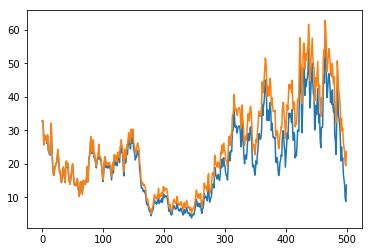

In [42]:
plt.plot(V_trajectory_bs)
plt.plot(money_bs)

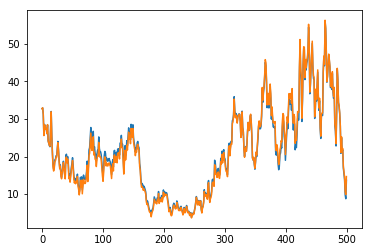

In [43]:
plt.plot(V_trajectory)
plt.plot(money)

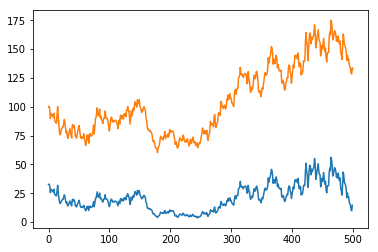

In [26]:
plt.plot(money)
plt.plot(stock_prices)

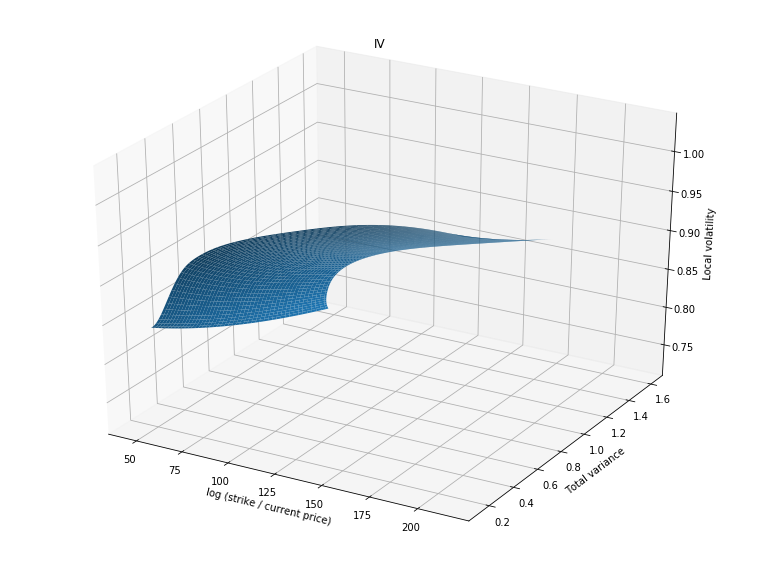

In [27]:
fig = plt.figure(figsize=(45, 10))

ax2 = fig.add_subplot(132, projection='3d')
ax2.plot_surface(K_extended, T_extended, theta)
ax2.set_title('IV')
ax2.set_xlabel('log (strike / current price)')
ax2.set_ylabel('Total variance')
ax2.set_zlabel('Local volatility')
# ax2.set_zlim(0.0, 0.5)

plt.show()

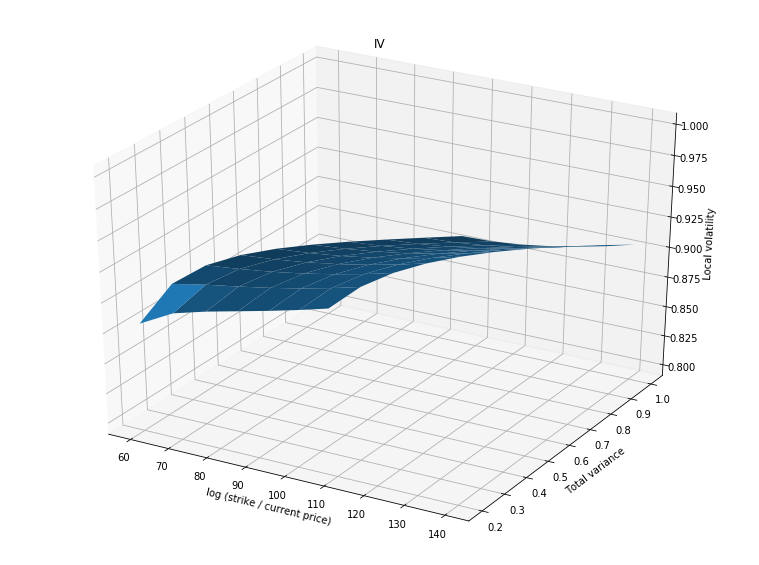

In [28]:
fig = plt.figure(figsize=(45, 10))

ax2 = fig.add_subplot(132, projection='3d')
ax2.plot_surface(*np.meshgrid(K_grid, T_grid), implied_volatilities)
ax2.set_title('IV')
ax2.set_xlabel('log (strike / current price)')
ax2.set_ylabel('Total variance')
ax2.set_zlabel('Local volatility')
# ax2.set_zlim(0.0, 0.5)

plt.show()